In [135]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

# Notes on calculations

Calulation and definitions found here: 

https://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/ModelEvaluation.html#1_Introduction

## Although they say observed - predicted which is clearly wrong

In [136]:
path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv"

small_fire = fv.prep_fire_files(path)
small_fire = small_fire[~small_fire.geometry.isna()]

fire = fv.prep_fire_files(path)
fire = fire[~fire.geometry.isna()]

In [137]:
#fire[fire.fireID == '9791'].t.max() ## Yes, has FWI from when fires is not burning. 

#fire = fire[~fire.geometry.isna()] ## Subset to just when fires are burning (Should do? What about lead up to?)




In [138]:
### Ok, see if you can get rid of duplicates for the purposes of plotting 

small_fire = small_fire[['GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'pre_fire']]
small_fire = small_fire.drop_duplicates()
#small_fire.columns

In [139]:
##### Functions for per-FWI value sampling

def get_mid(interval):
    interval.astype()
    return interval.mid

## Calculate the varience at different FWI and lag values
#small_fire["FWI_round"] = np.round(small_fire.FWI)
#small_fire["FWI_round"][small_fire["FWI_round"] >= 17] = 17
nbins = 10
small_fire["FWI_intervals"] = pd.qcut(small_fire.FWI.dropna(), nbins)
small_fire["FWI_round"] = small_fire.FWI_intervals.apply(lambda x: get_mid(x))



def calc_bias(df, i):
    tmp = np.sum( df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
    #print(len(df["FWI"]))
    return(tmp)


def RMSE(df, i):
    tmp = (np.sum((df[f"FWI_lead_{i}"] - df["FWI"])**(2))/len(df[f"FWI_lead_{i}"]))**(1/2)
    return(tmp)


def FWI_bootstrap_stat_quantiles(df,i,  num_samps, stat, resample_n = 50, quantiles = [0.025, 0.975]):
    '''
    like function above, but passes df so that it works with group_by better
    '''
    stat_list = []
    
    if(resample_n is None):
        resample_n = len(df)
        
    for n in range(1, num_samps):
        
        resample = df[["FWI", f"FWI_lead_{i}"]].dropna().sample(n = (resample_n), replace = True)
        # print(len(resample.iloc[:, 0].unique()))
        # print(len(resample.iloc[:, 0].dropna().unique()))
        #get_stat = stat(resample.iloc[:, 0], resample.iloc[:, 1])
        get_stat = stat(resample, i)
        # print(get_stat)
        # print(1 - (np.sum((resample.iloc[:, 0] - resample.iloc[:, 1])**(2)) / np.sum((resample.iloc[:, 0] - resample.iloc[:, 1].mean())**(2))))
        stat_list.append(get_stat)
    #print(stat_list)
    
    #print(np.quantile(stat_list, q = quantiles))
    list_of_tuples = list(zip(np.quantile(stat_list, q = quantiles), quantiles))
    quant_df = pd.DataFrame(list_of_tuples, columns=[f'{stat.__name__}_of_{resample.columns[0]}_and_{resample.columns[1]}', 'quantiles'])
    return(quant_df)

In [140]:
def fr_sq(s, s_pred):
    n = 1 - (np.sum((s - s_pred)**(2)) / np.sum((s - s_pred.mean())**(2)))
    return(n)
    
def fbias(s, s_pred):
    n = np.sum( (s_pred - s) )/len(s_pred)
    return(n)

def frmse(s, s_pred):
    n = ((np.sum((s_pred - s)**2))/len(s_pred))**(1/2)
    return(n)
    

def bootstrap_stat_quantiles(df, num_samps, stat, quantiles = [0.025, 0.975], resample_n = None):
    '''
    df (dataframe) a dataframe where the first column is s and second is s_pred
    '''
    stat_list = []
    
    if(resample_n is None):
        resample_n = len(df)
    
    for n in range(1, num_samps):
        
        resample = df.dropna().sample(n = (resample_n), replace = True)
        # print(len(resample.iloc[:, 0].unique()))
        # print(len(resample.iloc[:, 0].dropna().unique()))
        get_stat = stat(resample.iloc[:, 0], resample.iloc[:, 1])
        # print(get_stat)
        # print(1 - (np.sum((resample.iloc[:, 0] - resample.iloc[:, 1])**(2)) / np.sum((resample.iloc[:, 0] - resample.iloc[:, 1].mean())**(2))))
        stat_list.append(get_stat)
    #print(stat_list)
    
    #print(np.quantile(stat_list, q = quantiles))
    list_of_tuples = list(zip(np.quantile(stat_list, q = quantiles), quantiles))
    quant_df = pd.DataFrame(list_of_tuples, columns=[f'{stat.__name__}_of_{resample.columns[0]}_and_{resample.columns[1]}', 'quantiles'])
    return(quant_df)
    
    

In [141]:

for i in range(1,9):
    small_fire[f"fwi_error_{i}"] =small_fire["FWI"] - small_fire[f"FWI_lead_{i}"]

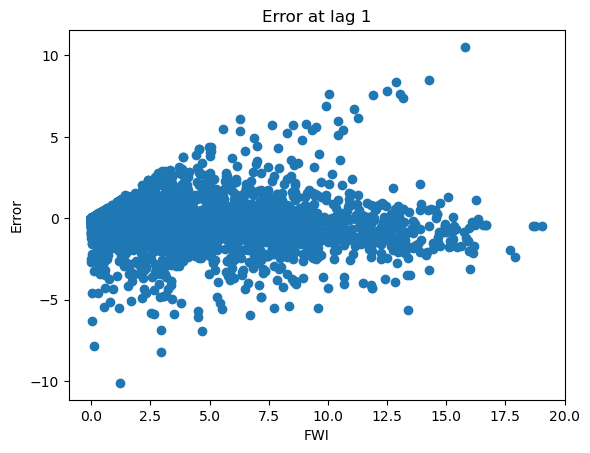

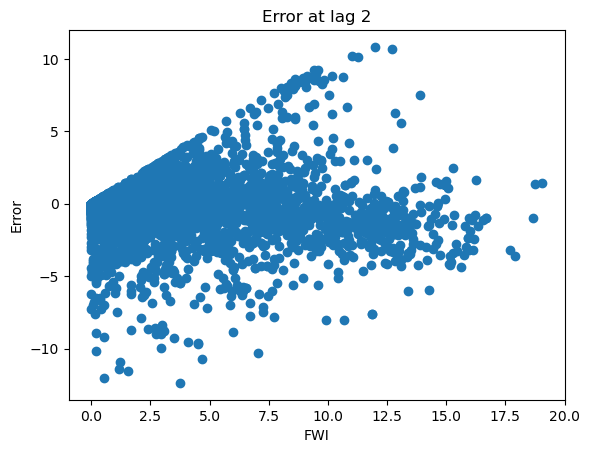

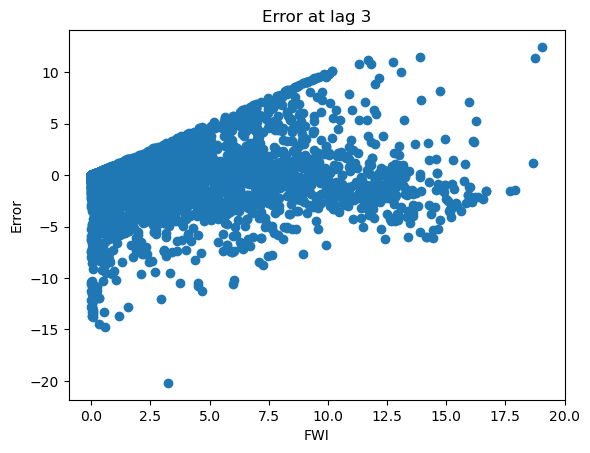

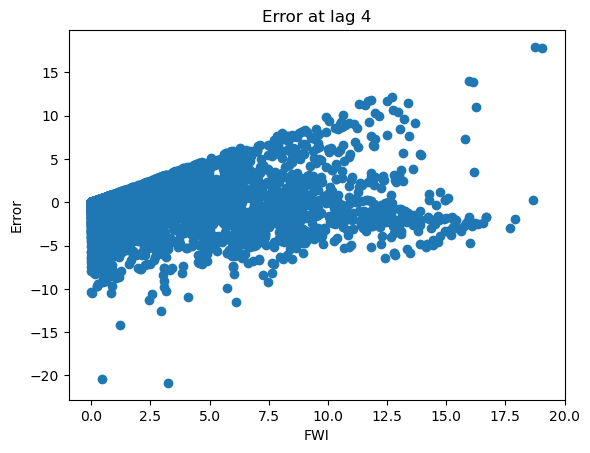

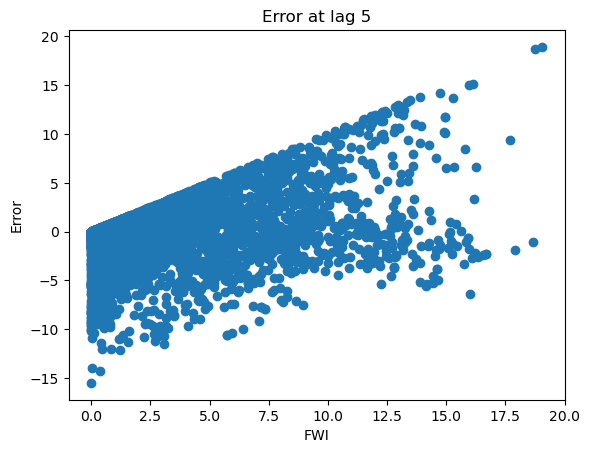

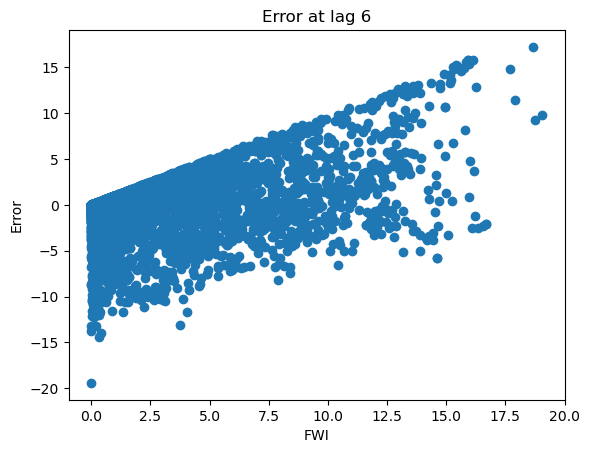

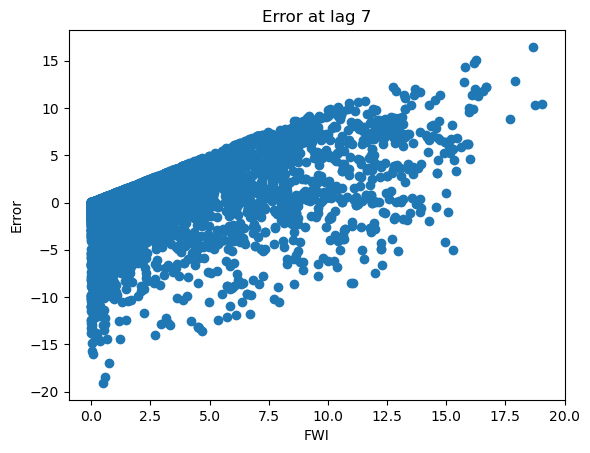

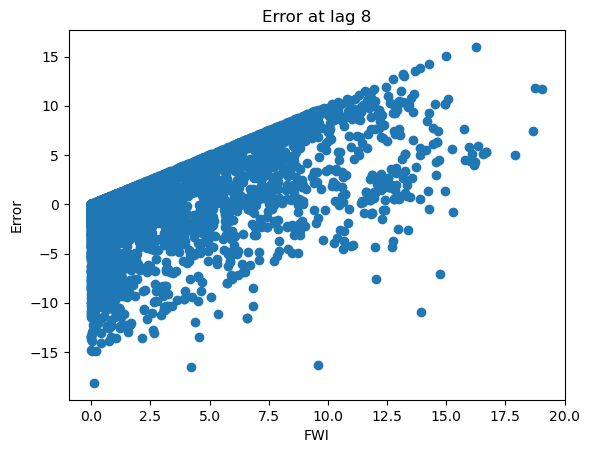

In [142]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"fwi_error_{i}"])
    plt.xlabel("FWI")
    plt.ylabel("Error")
    plt.title(f"Error at lag {i}")
    plt.show()

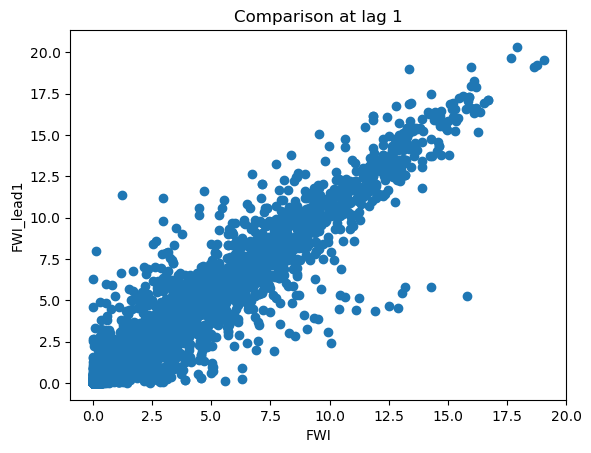

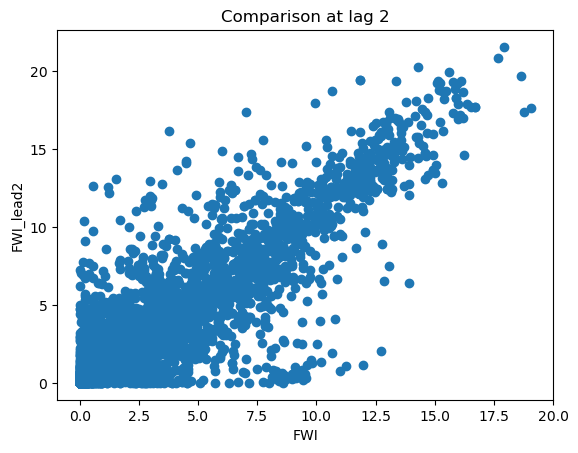

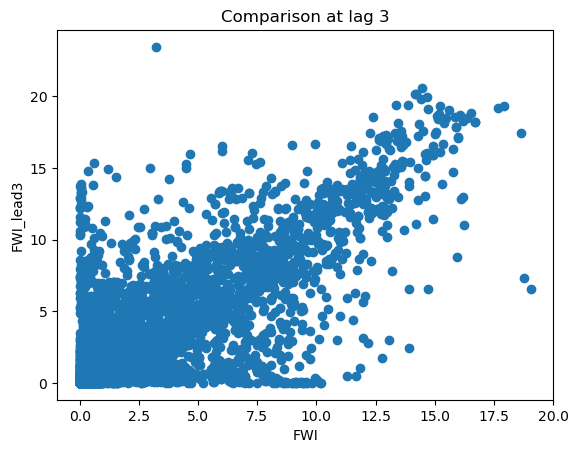

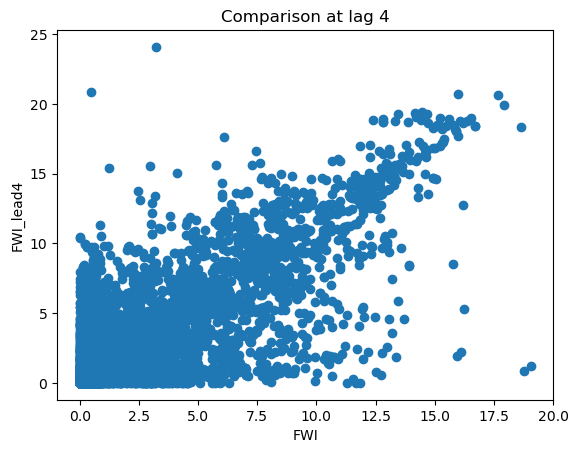

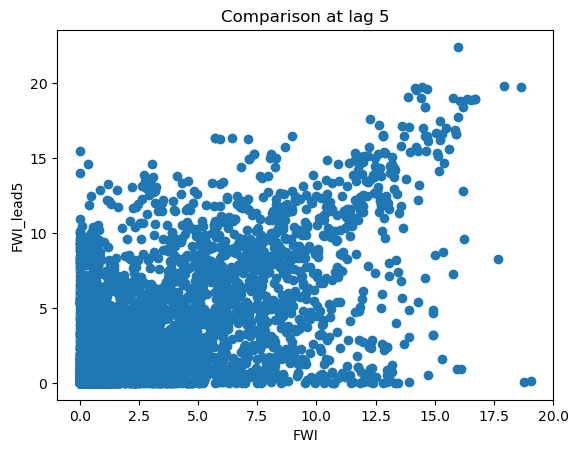

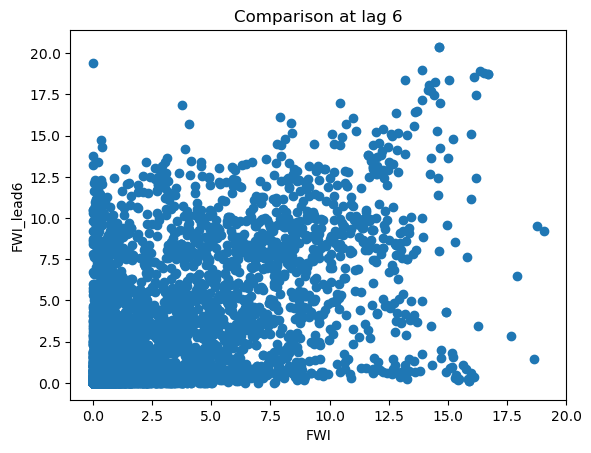

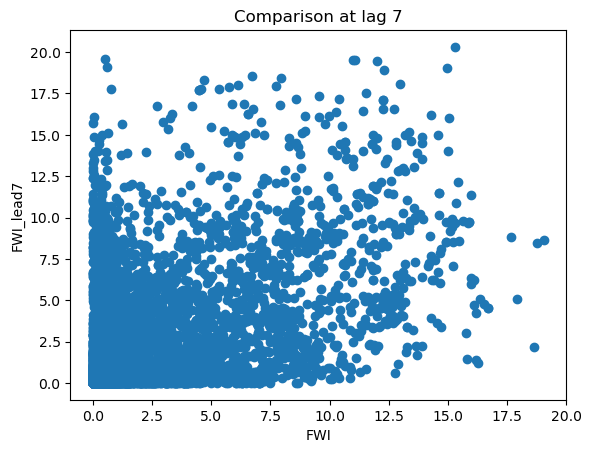

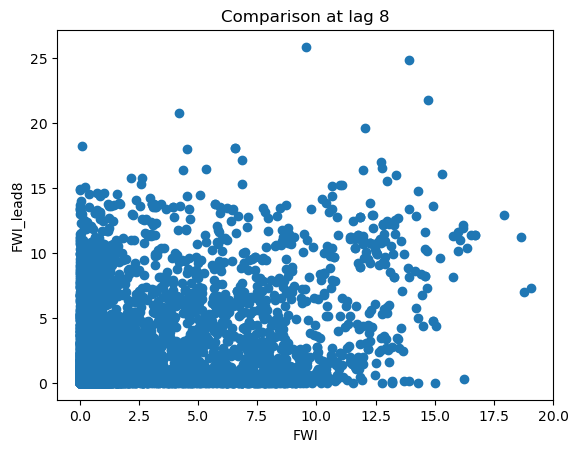

In [143]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [ ]:
len(small_fire)

In [ ]:
len(small_fire)

In [ ]:
for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    plt.scatter(small_fire.FWI, small_fire[f"FWI_lead_{i}"])
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    plt.title(f"Comparison at lag {i}")
    plt.show()

In [ ]:
### BAD: BUT I JUST WANT TO LOOK TO SEE IF SUPER DIFFERENT

#small_fire["FWI"] = small_fire["GEOS-5.IMERGEARLY"]
#fire["FWI"] = fire["GEOS-5.IMERGEARLY"]

log_fire = small_fire
small_fire.columns
#log_fire = np.log(small_fire[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3','FWI_lead_4', 'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']] + 1)

In [ ]:
# boot_df = small_fire.sample(n = len(small_fire)**2, replace = True, random_state = 4001, axis =0, ignore_index = True)

# print(len(boot_df))

In [ ]:
np.quantile(small_fire[["FWI"]].dropna(), q = [0.025, 0.0975])
  

In [ ]:
  
    
test_rsq = bootstrap_stat_quantiles(small_fire[["FWI", "FWI_lead_1"]].dropna(), num_samps = 300, stat = fr_sq, quantiles = [0.025, 0.975])

In [ ]:
#bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 300, stat = r_sq, quantiles = quantiles)

#r_sq(log_fire[["FWI"]].dropna(), log_fire[[f"FWI_lead_{i}"]].dropna())



In [ ]:
import seaborn as sns 

r_sq_list = []
bias_list = []
rmse_list = []
iterator = []

quantiles = [0.025, 0.975]
data = {'quantiles': quantiles}

boot_rmse = pd.DataFrame(data)
boot_r_sq = pd.DataFrame(data)
boot_bias = pd.DataFrame(data)

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=log_fire, x="FWI", y=f"FWI_lead_{i}", marker="+") 
    plt.plot(range(0,28), range(0,28), color = "black")
    plt.xlabel("FWI")
    plt.ylabel(f"FWI_lead{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((log_fire.FWI - log_fire[f"FWI_lead_{i}"])**(2)) / np.sum((log_fire.FWI - log_fire.FWI.mean())**(2)))
    bias = np.sum( log_fire[f"FWI_lead_{i}"] - log_fire.FWI )/len(log_fire[f"FWI_lead_{i}"])
    rmse = ((np.sum((log_fire[f"FWI_lead_{i}"] - log_fire.FWI)**2))/len(log_fire[f"FWI_lead_{i}"]))**(1/2)
    #print(log_fire[["FWI", f"FWI_lead_{i}"]])
    b_rsq = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 1000, stat = fr_sq, quantiles = quantiles)
    b_bias = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 1000, stat = fbias, quantiles = quantiles)
    b_rmse = bootstrap_stat_quantiles(log_fire[["FWI", f"FWI_lead_{i}"]].dropna(), num_samps = 1000, stat = frmse, quantiles = quantiles)
    ci_bias = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, num_samps = 300, stat = calc_bias, quantiles = quantiles)
    ci_RMSE = mall_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, num_samps = 300, stat = calc_bias, quantiles = quantiles)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    rmse_list.append(rmse)
    r_sq_list.append(r_sq)
    bias_list.append(bias)
    iterator.append(i)
    boot_rmse = boot_rmse.merge(b_rmse, on = "quantiles")
    boot_r_sq = boot_r_sq.merge(b_rsq, on = "quantiles")
    boot_bias = boot_bias.merge(b_bias, on = "quantiles")
    
    plt.show()

decay_stats = pd.DataFrame({"lag_day": iterator, "RMSE": rmse_list, "r_sq": r_sq_list, "bias":bias_list, })

# here "*" is used as a marker for scatterplot 

In [ ]:
boot_rmse

In [ ]:
stats = ["RMSE", "r_sq", "bias"]
b_sts = [ boot_rmse, boot_r_sq, boot_bias ]

for s,b in zip(stats, b_sts):
    plt.plot(decay_stats.lag_day, decay_stats[s], label = "All FWI Values")
    upper = b.iloc[0, 1:]
    lower = b.iloc[1, 1:]
    #print(b)
    plt.fill_between(decay_stats.lag_day, lower, upper, alpha=0.2, label='Confidence Interval')
    plt.xlabel("Forecast Lead Time")
    plt.ylabel(s)
    plt.show()

In [ ]:
bins = 10
slices = np.linspace(0, 100, bins+1, True)
slices

In [ ]:
tmp = pd.qcut(small_fire.FWI.dropna(), 20, precision = 0)

tmp

In [ ]:
#small_fire.FWI_round.unique()

In [ ]:
#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

for i in range(1,9):
    test_var = small_fire.groupby("FWI_round")[f"FWI_lead_{i}"].var().reset_index()
    #plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Variance")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

In [ ]:
boot_df

In [ ]:
max(quantiles)

In [ ]:
quantiles = [0.025, 0.975]
data = {'quantiles': quantiles}

#ci_df = pd.DataFrame(data)

for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(calc_bias, i = i).reset_index()
    #print(test_var)
    ci = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, num_samps = 300, stat = calc_bias, quantiles = quantiles)
    #print(ci)
    #ci_df = ci_df.merge(ci, on = "quantiles")
    upper = ci[ci.quantiles == max(quantiles)].iloc[:, 0]
    lower = ci[ci.quantiles == min(quantiles)].iloc[:, 0]
    #print(b)
    plt.fill_between(test_var.FWI_round, lower.astype("float64"), upper.astype("float64"), alpha=0.2, label='', color = colors[i])
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

In [ ]:
for i in range(1,9):
    test_var = small_fire.groupby("FWI_round").apply(RMSE, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"FWI_lead_{i}"})
    ci = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, num_samps = 300, stat = RMSE, quantiles = quantiles)
    #print(ci)
    #ci_df = ci_df.merge(ci, on = "quantiles")
    upper = ci[ci.quantiles == max(quantiles)].iloc[:, 0]
    lower = ci[ci.quantiles == min(quantiles)].iloc[:, 0]
    #print(b)
    plt.fill_between(test_var.FWI_round, lower.astype("float64"), upper.astype("float64"), alpha=0.2, label='', color = colors[i])
    #print(test_var)
    plt.plot(test_var.FWI_round, test_var[f"FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

# Now try to see if I can capture "changes in the timeseries". 

The goal is to find a mechnism that rewards capturing inflection points. This could have a couple of meanings: 

"How many days in advance did we get the inflection point correct" <-- possbily useful interpretation


"Were we able to spot the inflection point when the 


"Were we better at predicting the weather when it was getting hotter(more FWI) ore colder (less FWI)?"
- Calculate deltas, color-code scatterplots by deltas? Calculate r^2 on binned-deltas like I'm doing with Bias/ variance? 
- plot delta vs delta like above
- somehow plot delta skill one axis, FWI on other
    - T_4 - T_3, indexed by T_4  compared to forecasted T_4 - T_3 @ T_4 (actual) (Aka "The difference between 
        - FWI @T_3 = 10 FWI @T_4 = 16, forecastsed @T_3 was 6 and @ T_4 was 9. "Real delta" was 6, "Forecasted delta" was 3. @ FWI of 16, Delta forecast was off by 3



In [ ]:
small_fire

In [ ]:
fire_delta = fire.sort_values(by = ["fireID", "t"])

In [ ]:
def group_level_diff(df, var):
    df["diff_" + var] = df[var].diff()
    return(df)

In [ ]:
fire_delta = fire_delta[["fireID", "t", 'GEOS-5.IMERGEARLY',
       'FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8']]

#fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index()

In [ ]:
# smol = fire_delta[fire_delta.fireID == "10013"]

# smol["diff_FWI"] = smol.FWI.diff()
# #smol[~smol.FWI.isna()]
# smol[smol.t >= "2023-05-03"]

In [ ]:
fire_delta = fire_delta[fire_delta.t.str.contains("12:00:00")]

fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, "FWI").reset_index( drop = True)


for i in range(1,9):
    fire_delta = fire_delta.groupby("fireID").apply(group_level_diff, f"FWI_lead_{i}").reset_index( drop = True)
fire_delta

In [ ]:
fire_delta.columns

In [ ]:
### Drop duplicates to account for oversampling

fire_delta = fire_delta[['FWI', 'FWI_lead_1', 'FWI_lead_2', 'FWI_lead_3', 'FWI_lead_4',
       'FWI_lead_5', 'FWI_lead_6', 'FWI_lead_7', 'FWI_lead_8', 'diff_FWI', 'diff_FWI_lead_1', 'diff_FWI_lead_2',
       'diff_FWI_lead_3', 'diff_FWI_lead_4', 'diff_FWI_lead_5',
       'diff_FWI_lead_6', 'diff_FWI_lead_7', 'diff_FWI_lead_8']]
fire_delta = fire_delta.drop_duplicates()


### Summary stats for CHANGE in FWI predictions

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, x="diff_FWI", y=f"diff_FWI_lead_{i}", marker="+") 
    max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.xlabel("diff_FWI")
    plt.ylabel(f"diff_FWI_lead_{i}")
    
    ## Stats
    r_sq = 1 - (np.sum((fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"])**(2)) / np.sum((fire_delta.diff_FWI - fire_delta.diff_FWI.mean())**(2)))
    bias = np.sum(fire_delta[f"diff_FWI_lead_{i}"] - fire_delta.diff_FWI )/len(fire_delta.diff_FWI)
    #plt.title(f"Comparison at lag {i}")
    print(f"Summary Statistics for lag {i}")
    print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    print("Overall Bias/ mean predictor error: " + str(bias) )
    plt.show()
    

In [ ]:
fire_delta

In [ ]:
#type(fire_delta.FWI)

#tmp = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True)




In [ ]:
### See if there is systematic bias in the differenced stuff

## Calculate the varience at different FWI and lag values
fire_delta["FWI_round"] = np.round(fire_delta.FWI)
fire_delta["FWI_round"][fire_delta["FWI_round"] > 17] = 17
#fire_delta["FWI_binned"] = pd.cut(fire_delta.FWI.values, bins= 5, include_lowest = True) ## Becomes catagorical data an messes up plotting below


# def calc_bias(df, i):
#     tmp = np.sum(df[f"FWI_lead_{i}"] - df["FWI"])/len(df[f"FWI_lead_{i}"])
#     return(tmp)

def calc_bias_diff(df, i):
    tmp = np.sum( df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])/len(df[f"diff_FWI_lead_{i}"])
    #print(len(df[f"diff_FWI_lead_{i}"]))
    #print(df["FWI_round"].unique())
    return(tmp)

def RMSE_diff(df, i):
    tmp = (np.sum((df[f"diff_FWI_lead_{i}"] - df["diff_FWI"])**(2))/len(df[f"diff_FWI_lead_{i}"]))**(1/2)
    return(tmp)

    

#cmap = plt.get_cmap('viridis')
colors = plt.cm.viridis(np.linspace(0,1,9))

bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply(calc_bias_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"Bias ")
    plt.title("Bias in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()

In [ ]:
bin_var = "FWI_round" # "FWI_round"
for i in range(1,9):
    test_var = fire_delta.groupby(bin_var).apply( RMSE_diff, i = i).reset_index()
    #print(test_var)
    test_var = test_var.rename(columns={0:f"diff_FWI_lead_{i}"})
    plt.plot(test_var[bin_var], test_var[f"diff_FWI_lead_{i}"], label = f"Lead {i}", color = colors[i])
    plt.xlabel("FWI")
    plt.ylabel(f"RMSE ")
    plt.title("RMSE in difference errors")
    plt.legend()
    #plt.title(f"Comparison at lag {i}")
plt.show()    

In [ ]:
## Plot error by FWI

for i in range(1,9):
    # plt.scatter(small_fire.FWI, (small_fire[f"fwi_error_{i}"] * small_fire[f"fwi_error_{i}"])**(1/2))
    sns.jointplot(data=fire_delta, y="FWI", x=fire_delta.diff_FWI - fire_delta[f"diff_FWI_lead_{i}"], marker="+") 
    #max_of_max = round(max(fire_delta[f"diff_FWI_lead_{i}"].max(), fire_delta.diff_FWI.max()))
    #min_of_min = round(min(fire_delta[f"diff_FWI_lead_{i}"].min(), fire_delta.diff_FWI.min()))
    
    
    #plt.plot(range(min_of_min, max_of_max), range(min_of_min, max_of_max), color = "black")
    plt.ylabel("FWI")
    plt.xlabel(f" Error in differece from lead_{i}")
    
    ## Stats
    plt.show()

### Trying to recreate the error statistics by forecast lead time with FWI as the color bar instead of the other way around 

In [177]:
#nbins = 5
# small_fire["FWI_intervals"] = pd.qcut(small_fire.FWI.dropna(), nbins)
# small_fire["FWI_round"] = small_fire.FWI_intervals.apply(lambda x: get_mid(x))

nbins = len(small_fire["FWI_intervals"].dropna().unique())
small_fire["FWI_intervals"] = pd.cut(small_fire.FWI, [small_fire.FWI.min(), 2.5, 7, small_fire.FWI.max()], include_lowest = True, labels= None,  right=True)
small_fire["FWI_round"] = small_fire.FWI_intervals.apply(lambda x: get_mid(x))
small_fire["FWI_label"] = pd.cut(small_fire.FWI, [small_fire.FWI.min(), 2.5, 7, small_fire.FWI.max()], include_lowest = True, labels= ["<2.5", "2.5-7", ">7"],  right=True)

#foo = pd.cut(small_fire.FWI, [small_fire.FWI.min(), 2.5, 7, small_fire.FWI.max()], include_lowest = True, labels= ["<2.5", "2.5-7", ">7"],  right=True)
#foo


In [216]:
fwi_colors = plt.cm.copper(np.linspace(0,1,nbins))

In [179]:
# ci = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, num_samps = 300, stat = calc_bias, quantiles = quantiles)


In [180]:
# boot_rmse

In [198]:
#small_fire["FWI_round"].hist()

In [181]:
%%capture --no-stderr

r_sq_list = []
bias_list = []
rmse_list = []
iterator = []

quantiles = [0.025,0.5, 0.975]
data = {'quantiles': quantiles}


### Generate staring DFs with a multi-index 

# Use numpy to create a grid of these elements
level1_grid, level2_grid = np.meshgrid(quantiles, [*small_fire["FWI_round"].dropna().astype("float64")])

# Flatten the grids and create a list of tuples
index_tuples = list(zip(level1_grid.flatten(), level2_grid.flatten()))

# Create the MultiIndex
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=[ 'quantiles', "FWI_round"])



boot_rmse = pd.DataFrame(data)
boot_r_sq = pd.DataFrame(data)
boot_bias = pd.DataFrame(data)

b_ci_bias = pd.DataFrame(index=multi_index) #pd.DataFrame({ "FWI_round" :[*small_fire["FWI_round"].dropna().astype("float64")]})
b_ci_RMSE = pd.DataFrame(index=multi_index) #pd.DataFrame({ "FWI_round" : [*small_fire["FWI_round"].dropna().astype("float64")]})

boot_samps = 1000


for i in range(1,9):

    
    ## Stats
    r_sq = 1 - (np.sum((small_fire.FWI - small_fire[f"FWI_lead_{i}"])**(2)) / np.sum((small_fire.FWI - small_fire.FWI.mean())**(2)))
    bias = np.sum( small_fire[f"FWI_lead_{i}"] - small_fire.FWI )/len(small_fire[f"FWI_lead_{i}"])
    rmse = ((np.sum((small_fire[f"FWI_lead_{i}"] - small_fire.FWI)**2))/len(small_fire[f"FWI_lead_{i}"]))**(1/2)
    #print(small_fire[["FWI", f"FWI_lead_{i}"]])
    b_rsq = bootstrap_stat_quantiles(small_fire[["FWI", f"FWI_lead_{i}"]].dropna(), resample_n = 200,  num_samps =  boot_samps, stat = fr_sq, quantiles = quantiles)
    b_bias = bootstrap_stat_quantiles(small_fire[["FWI", f"FWI_lead_{i}"]].dropna(), resample_n = 200, num_samps = boot_samps, stat = fbias, quantiles = quantiles)
    b_rmse = bootstrap_stat_quantiles(small_fire[["FWI", f"FWI_lead_{i}"]].dropna(), resample_n = 200, num_samps = boot_samps, stat = frmse, quantiles = quantiles)
    ci_bias = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i,resample_n = 200, num_samps = boot_samps, stat = calc_bias, quantiles = quantiles)
    ci_RMSE = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, resample_n = 200, num_samps = boot_samps, stat = RMSE, quantiles = quantiles)
    #plt.title(f"Comparison at lag {i}")
    # print(f"Summary Statistics for lag {i}")
    # print("R^2 from 1:1 (Variance explained): " + str(r_sq) )
    # print("Overall Bias/ mean predictor error: " + str(bias) )
    rmse_list.append(rmse)
    r_sq_list.append(r_sq)
    bias_list.append(bias)
    iterator.append(i)
    boot_rmse = boot_rmse.merge(b_rmse, on = "quantiles")
    boot_r_sq = boot_r_sq.merge(b_rsq, on = "quantiles")
    boot_bias = boot_bias.merge(b_bias, on = "quantiles")
    b_ci_bias = b_ci_bias.merge(ci_bias,  on = ['FWI_round', 'quantiles'])
    b_ci_bias =  b_ci_bias.drop_duplicates()
    b_ci_RMSE = b_ci_RMSE.merge(ci_RMSE,  on = ['FWI_round', 'quantiles'])### The merging here seems to be what is Memory intensive, along with the 'resample_n' parameter, to a lesser extent
    b_ci_RMSE = b_ci_RMSE.drop_duplicates()

decay_stats = pd.DataFrame({"lag_day": iterator, "RMSE": rmse_list, "r_sq": r_sq_list, "bias":bias_list, })

/tmp/ipykernel_4150/2113605629.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci_bias = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i,resample_n = 200, num_samps = 1000, stat = calc_bias, quantiles = quantiles)
/tmp/ipykernel_4150/2113605629.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci_RMSE = small_fire.groupby("FWI_round").apply(FWI_bootstrap_stat_quantiles, i = i, resample_n = 200, num_samps = 1000, stat = RMSE, quantiles = quantiles)
/tmp/ipykernel_4150/2113605629.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

1.249500003915
4.75
13.0265


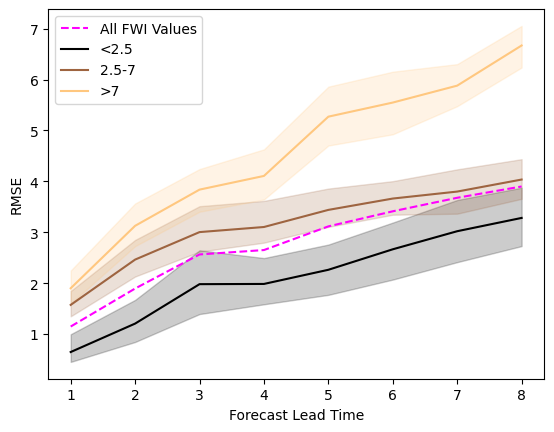

1.249500003915
4.75
13.0265


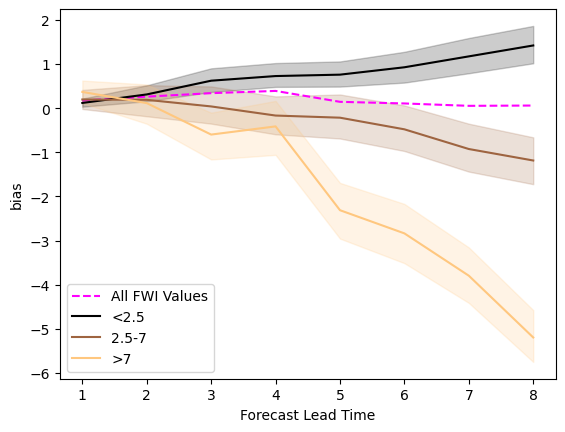

In [220]:
stats = ["RMSE", "bias"] #  "r_sq",
b_sts = [ boot_rmse,  boot_bias ] # boot_r_sq,
c_sts = [b_ci_RMSE, b_ci_bias]#[RMSE, calc_bias]
l_sts = range(0, len(small_fire["FWI_round"].dropna().unique()))
#int_sts = small_fire["FWI_intervals"].sort_values().dropna().unique()

ctime = datetime.now()
date = ctime.strftime("%Y-%m-%d")

for s,b,c in zip(stats, b_sts, c_sts):
    plt.plot(decay_stats.lag_day, decay_stats[s], label = "All FWI Values", color = "magenta", linestyle='dashed')
    upper = b.iloc[0, 1:]
    lower = b.iloc[1, 1:]
    #print(b)
    #plt.fill_between(decay_stats.lag_day, lower, upper, alpha=0.1, label='Confidence Interval', color="none", hatch="X")
    for n, l, i in zip(small_fire["FWI_round"].sort_values().dropna().unique(), l_sts, int_sts):
        print(n)
        #fwi_upper = c[(c.index == n) & (c.quantiles == min(quantiles))].iloc[:, 1:].transpose().values
        #fwi_lower = c[(c.index == n) & (c.quantiles == max(quantiles))].iloc[:, 1:].transpose().values
        # fwi_upper = c[(c.index == n) & (c.quantiles == min(quantiles))].iloc[:, 1:].values
        # fwi_lower = c[(c.index == n) & (c.quantiles == max(quantiles))].iloc[:, 1:].values
        fwi_upper = c[(c.index == n) & (c.quantiles == min(quantiles))].iloc[:, 1:].to_numpy().flatten()
        fwi_lower = c[(c.index == n) & (c.quantiles == max(quantiles))].iloc[:, 1:].to_numpy().flatten()
        fwi_mid = c[(c.index == n) & (c.quantiles == 0.5)].iloc[:, 1:].to_numpy().flatten()
        plt.plot(decay_stats.lag_day, fwi_mid, color = fwi_colors[l], label = str(*small_fire[small_fire.FWI_round == n].dropna().FWI_label.astype("str").unique()))
        #print(fwi_upper)
        #### Need to be sampling the mean I think to get a line
        plt.fill_between(decay_stats.lag_day, fwi_lower, fwi_upper, alpha=0.2, color = fwi_colors[l])
        


    plt.xlabel("Forecast Lead Time")
    plt.ylabel(s)
    plt.legend()
    plt.show()
    plt.savefig(f"/projects/old_shared/fire_weather_vis/Lightning_analysis/some_figs/stats_by_leadtime_{date}_small_bootstrap.png")

In [192]:
l_sts

range(1, 3)

In [191]:
small_fire["FWI_round"].sort_values().dropna().unique()

[1.2495, 4.7500, 13.0265]
Categories (3, float64): [1.2495 < 4.7500 < 13.0265]

In [56]:
ci_bias.merge(ci_RMSE,)

,calc_bias_of_FWI_and_FWI_lead_1,quantiles,RMSE_of_FWI_and_FWI_lead_1
FWI_round,,,
0.016350003915,0.017795,0.025,0.028278
0.016350003915,0.421995,0.975,1.244428
0.11535000000000001,0.019888,0.025,0.114697
0.11535000000000001,0.305254,0.975,1.768138
0.2985,-0.018372,0.025,0.146229
0.2985,0.354047,0.975,1.007169
0.5165,-0.064233,0.025,0.114374
0.5165,0.378426,0.975,0.980901
0.7725,-0.127940,0.025,0.203770


In [79]:
c = b_ci_bias

c[(c.index == n) & (c.quantiles == min(quantiles))]

TypeError: 'numpy.ndarray' object is not callable

In [75]:
c[(c.index == n) & (c.quantiles == min(quantiles))].drop_duplicates()

,quantiles,calc_bias_of_FWI_and_FWI_lead_1,calc_bias_of_FWI_and_FWI_lead_2,calc_bias_of_FWI_and_FWI_lead_3,calc_bias_of_FWI_and_FWI_lead_4,calc_bias_of_FWI_and_FWI_lead_5,calc_bias_of_FWI_and_FWI_lead_6,calc_bias_of_FWI_and_FWI_lead_7,calc_bias_of_FWI_and_FWI_lead_8
FWI_round,,,,,,,,,
2.441,0.025,-0.30792,-0.291829,-0.534291,-0.715871,-0.689211,-0.752204,-1.159136,-1.180228


In [107]:
np.array(c[(c.index == n) & (c.quantiles == min(quantiles))].iloc[:, 1:])

array([[0.85986117, 1.24640462, 1.46209779, 1.56214258, 1.61267584,
        1.80695297, 1.70575021, 2.03807141]])

In [89]:
fwi_upper

array([[0.85986117],
       [1.24640462],
       [1.46209779],
       [1.56214258],
       [1.61267584],
       [1.80695297],
       [1.70575021],
       [2.03807141]])

0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
Name: lag_day, dtype: int64

In [157]:
small_fire.FWI.quantile([0.025, 0.25,0.5,0.75, 0.975])

0.025     0.000263
0.250     0.299517
0.500     0.912172
0.750     4.052578
0.975    12.618683
Name: FWI, dtype: float64

In [92]:
upper

frmse_of_FWI_and_FWI_lead_1    0.523439
frmse_of_FWI_and_FWI_lead_2    0.943894
frmse_of_FWI_and_FWI_lead_3    1.073768
frmse_of_FWI_and_FWI_lead_4    1.188330
frmse_of_FWI_and_FWI_lead_5    1.719065
frmse_of_FWI_and_FWI_lead_6    1.759903
frmse_of_FWI_and_FWI_lead_7    1.951575
frmse_of_FWI_and_FWI_lead_8    2.410176
Name: 0, dtype: float64

In [112]:
c[(c.index == n) & (c.quantiles == min(quantiles))].iloc[:, 1:].to_numpy().flatten()

array([0.85986117, 1.24640462, 1.46209779, 1.56214258, 1.61267584,
       1.80695297, 1.70575021, 2.03807141])

In [223]:
#plt.savefig('Regional_fire_growth_FWI.png')


AttributeError: module 'sys' has no attribute 'now'

In [227]:


#year = str(ctime.year

datetime.datetime(2024, 6, 26, 8, 28, 14, 756125)

'2024-06-26'